In [77]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

## AWGN 함수

In [ ]:
def awgn_(input, dB_snr):
    snr = 10**(dB_snr/10)
    signal_power = 1
    awgn_power = signal_power / snr
    # 텐서 계산을 위해 텐서 타입으로 변환
    awgn_power_tensor = torch.tensor(awgn_power, dtype=torch.float32)
    awgn = torch.sqrt(awgn_power_tensor / 2)*(
        torch.randn_like(input, dtype=torch.float32)+1j*torch.randn_like(input, dtype=torch.float32)
    )
    return input + awgn


### 2번 프로젝트
`tr_qpsk.csv`를 이용하여 딥러닝 기반의 QPSK 복조 (Decoder)를 학습한다.
이후 `te_qpsk.csv` 파일을 이용하여 정확도가 80% 이상인 모델을 사용하고자 한다.
이때 Ground Truth는 `*_dec.csv` 파일을 사용하여 지도학습을 수행한다.

### 전통적인 QPSK 변조 (Encoder)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1. QPSK 심볼 생성 함수
def qpsk_modulation(bits):
    """
    QPSK 변조 함수
    Args:
        bits (list): 입력 비트 스트림 (길이는 반드시 짝수여야 함)
    Returns:
        numpy.ndarray: 복소수 QPSK 심볼
    """
    if len(bits) % 2 != 0:
        raise ValueError("입력 비트 스트림의 길이는 짝수여야 합니다.")

    # 비트를 2비트 그룹으로 나눔
    bit_pairs = np.array(bits).reshape(-1, 2)

    # 매핑 테이블: 각 비트 쌍을 QPSK 심볼로 변환
    mapping = {
        (0, 0): 1 + 1j,  # 0도
        (0, 1): -1 + 1j,  # 90도
        (1, 1): -1 - 1j,  # 180도
        (1, 0): 1 - 1j   # 270도
    }

    # 비트 쌍을 복소수 QPSK 심볼로 변환
    symbols = np.array([mapping[tuple(pair)] for pair in bit_pairs])
    return symbols

# 2. 입력 비트 스트림
bits = [0, 0, 0, 1, 1, 1, 1, 0]  # 예제 비트 스트림

# 3. QPSK 변조 수행
qpsk_symbols = qpsk_modulation(bits)
print("QPSK 심볼:", qpsk_symbols)

# 4. QPSK 심볼 시각화
def plot_qpsk_constellation(symbols):
    """
    QPSK 신호의 성상도(Constellation Diagram)를 시각화
    Args:
        symbols (numpy.ndarray): 복소수 QPSK 심볼
    """
    plt.figure(figsize=(6, 6))
    plt.scatter(symbols.real, symbols.imag, color='red')
    plt.axhline(0, color='gray', linestyle='--')
    plt.axvline(0, color='gray', linestyle='--')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.title("QPSK Constellation Diagram")
    plt.xlabel("In-phase (Real)")
    plt.ylabel("Quadrature (Imaginary)")
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.show()

# 성상도 출력
plot_qpsk_constellation(qpsk_symbols)


In [79]:
# QPSK Decoder Model (CNN)
class QPSKDemodulationModel(nn.Module):
    def __init__(self):
        super(QPSKDemodulationModel, self).__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 4)
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x

In [80]:
# Training Set 준비
train_df = pd.read_csv('./data/tr_qpsk.csv', header=None)
# 복소수 형태로 변환
train_df[0] = train_df[0].str.replace('i', 'j')  # 'i'를 'j'로 변경 (Python 복소수 표기법에 맞춤)
train_complex_numbers = train_df[0].apply(lambda x: complex(x))

# 실수부와 허수부 분리
train_qpsk_real_parts = train_complex_numbers.apply(lambda x: x.real)
train_qpsk_imag_parts = train_complex_numbers.apply(lambda x: x.imag)

# Ground Truth (dec)
dec = np.loadtxt('./data/tr_dec.csv', delimiter=',')
# DataFrame 생성
train_df = pd.DataFrame({'Real': train_qpsk_real_parts, 
                         'Imaginary': train_qpsk_imag_parts, 
                         'dec': dec})

# Test Set 준비
test_df = pd.read_csv('./data/te_qpsk.csv', header=None)
test_df[0] = test_df[0].str.replace('i', 'j')
test_complex_numbers = test_df[0].apply(lambda x: complex(x))

test_qpsk_real_parts = test_complex_numbers.apply(lambda x: x.real)
test_qpsk_imag_parts = test_complex_numbers.apply(lambda x: x.imag)
dec = np.loadtxt('./data/te_dec.csv', delimiter=',')

test_df = pd.DataFrame({'Real': test_qpsk_real_parts, 
                        'Imaginary': test_qpsk_imag_parts, 
                        'dec': dec})

# PyTorch 텐서로 변환
X_train = torch.tensor(train_df[['Real','Imaginary']].values, dtype=torch.float32)
y_train = torch.tensor(train_df[['dec']].values, dtype=torch.long)
# Output이 0,1,2,3이므로 one-hot encoding을 수행 (Softmax 사용)
y_train = F.one_hot(y_train, 4).float()
print(X_train.shape, y_train.shape)
X_test = torch.tensor(test_df[['Real','Imaginary']].values, dtype=torch.float32)
y_test = torch.tensor(test_df[['dec']].values, dtype=torch.long)
# y_test_encode = F.one_hot(y_test, 4).fl/oat()
print(X_test.shape, y_test.shape)


torch.Size([500000, 2]) torch.Size([500000, 1, 4])
torch.Size([100000, 2]) torch.Size([100000, 1])


In [ ]:
# 모델 초기화
model = QPSKDemodulationModel()
criterion = nn.MSELoss()  # 손실 함수
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습
epochs = 10
batch_size = 128
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size][:,0]  # one-hot encoding에서 첫 번째 열 선택

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")


# 테스트
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    _, predicted = torch.max(test_outputs, 1)  # 가장 높은 확률의 클래스 선택

    accuracy = accuracy_score(y_test.numpy(), predicted.numpy())
    print(f"Test Accuracy: {accuracy:.2f}")

c:\Users\Kyounghwan-Kim\anaconda3\envs\space-search\lib\site-packages\torch\nn\modules\module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1/10, Loss: 8.3200
Epoch 2/10, Loss: 0.0004
Epoch 3/10, Loss: 0.0001
Epoch 4/10, Loss: 0.0000
Epoch 5/10, Loss: 0.0000
Epoch 6/10, Loss: 0.0000
Epoch 7/10, Loss: 0.0000
Epoch 8/10, Loss: 0.0000
Epoch 9/10, Loss: 0.0000
Epoch 10/10, Loss: 0.0000
Test Accuracy: 1.00


C:\Users\Kyounghwan-Kim\AppData\Local\Temp\ipykernel_22724\926797018.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_noise_tensor = torch.stack([torch.tensor(X_test_real_parts), torch.tensor(X_test_imag_parts)], dim=1)
c:\Users\Kyounghwan-Kim\anaconda3\envs\space-search\lib\site-packages\torch\nn\modules\module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


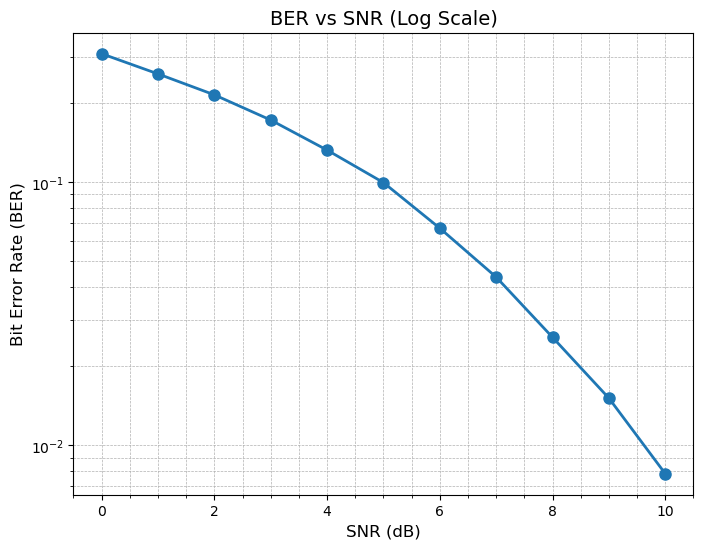

In [89]:
# BER 그래프
import matplotlib.pyplot as plt

# BER 계산 함수
def calculate_ber(original_bits, predicted_bits):
    errors = (original_bits != predicted_bits).sum().item()
    ber = errors / original_bits.numel()
    return ber

# BER 그래프 작성 함수
def plot_ber(snr_values, ber_values):
    """
    SNR 값과 BER 값을 사용해 semilogy 그래프를 그리는 함수
    
    Parameters:
    - snr_values: SNR 값들의 리스트 또는 numpy 배열 (X축 값)
    - ber_values: BER 값들의 리스트 또는 numpy 배열 (Y축 값)
    """
    plt.figure(figsize=(8, 6))
    plt.semilogy(snr_values, ber_values, marker='o', linestyle='-', linewidth=2, markersize=8)
    plt.title("BER vs SNR (Log Scale)", fontsize=14)
    plt.xlabel("SNR (dB)", fontsize=12)
    plt.ylabel("Bit Error Rate (BER)", fontsize=12)
    plt.grid(True, which="both", linestyle='--', linewidth=0.5)
    plt.minorticks_on()
    plt.show()

# SNR에 따른 BER 계산 및 그래프 작성
def evaluate_and_plot_ber(model, X_test, y_test, snr_range):
    ber_values = []
    for snr_db in snr_range:
        # 복소수로 변환
        X_test_complex = X_test[:, 0] + 1j*X_test[:, 1]
        # awgn 추가
        X_test_noise = awgn_(X_test_complex, snr_db)
        # 실수부와 허수부 분리
        X_test_real_parts = X_test_noise.real
        X_test_imag_parts = X_test_noise.imag
        # 텐서로 변환
        X_test_noise_tensor = torch.stack([torch.tensor(X_test_real_parts), torch.tensor(X_test_imag_parts)], dim=1)
        # 복조 수행
        model.eval()
        with torch.no_grad():
            predictions = model(X_test_noise_tensor)
            _, predicted_bits = torch.max(predictions, 1)
        # 정수 -> 비트 변환
        predicted_bits = predicted_bits.view(-1, 1)
        y_test = y_test.view(-1, 1)
        # BER 계산
        ber = calculate_ber(y_test, predicted_bits)
        ber_values.append(ber)

    # BER 그래프 작성
    plot_ber(snr_range, ber_values)

# SNR 범위 설정
snr_range = range(0, 11)  # 0 dB부터 10 dB까지

# BER 평가 및 그래프 작성
evaluate_and_plot_ber(model, X_test, y_test, snr_range)
